In [2]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from pymatgen.core.structure import Structure
from pymatgen.core.composition import Composition
from matminer.featurizers.site import CrystalNNFingerprint
from matminer.featurizers.structure import SiteStatsFingerprint

## 1. Prepare the data

In [4]:
# read the data
with open('data.json') as f:
    data = json.load(f)

In [5]:
# convert to dataframe
df = pd.DataFrame(data)
df['icsd_id'] = df['icsd_id'].astype('int')
df = df.set_index('icsd_id')

In [62]:
# convert cif to pymatgen structures for following processing
structs = []
for d in data:
    struct = Structure.from_str(d['cif'], fmt='cif')
    structs.append(struct)

df['structure'] = structs

In [7]:
df

,formula,cif,LoStOP,PTR
icsd_id,,,,
24530,Cu6 P2 S8,# generated using pymatgen\ndata_Cu3PS4\n_symm...,"[0.009337217233022086, 0.010831729800845383, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
152790,Cd4 Ga2 Cu0.4 Ag1.6 S8,# generated using pymatgen\ndata_Cd4Ga2Cu0.4Ag...,"[0.03109803750484976, 0.03077909940813822, 0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
627740,Mn0.2 Zn1.8 Cu4 Ge2 S8,# generated using pymatgen\ndata_Mn0.2Zn1.8Cu4...,"[0.011400596084659168, 0.012049471680690406, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
415452,Mn2 Cu4 Si2 S8,# generated using pymatgen\ndata_MnCu2SiS4\n_s...,"[0.029242009919614852, 0.029076293972385234, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
619770,Cd2 Cu4 Si2 S8,# generated using pymatgen\ndata_CdCu2SiS4\n_s...,"[0.04230761631943665, 0.04530611409087782, 0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...
300223,Cu4 Hg4 P4 S16,# generated using pymatgen\ndata_CuHgPS4\n_sym...,"[0.02149461025489845, 0.026243726450666027, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
49008,K4 Cu4 S4,# generated using pymatgen\ndata_KCuS\n_symmet...,"[0.00622953108475752, 0.0008893723663715246, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
42490,Mn2 Cu4 Ge2 S8,# generated using pymatgen\ndata_MnCu2GeS4\n_s...,"[0.0017758251299371222, 0.0, 0.001775825129937...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## 2. Get distance matrix

This part is optional, all the representations and distance matrix are pre-calculated

### 2.1 Convert compositions to the Peroidic Table representation

In [1]:
# periodic table representation, ptr
ptr = [
    ['H', '', '', '', '', '', '', '', '', '', '', '', '', '', '','', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'He'],
    ['Li', 'Be', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'B', 'C', 'N', 'O', 'F', 'Ne'],
    ['Na', 'Mg', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar'],
    ['K', 'Ca', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr'],
    ['Rb', 'Sr', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe'],
    ['Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn'],
    ['Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']
]

In [54]:
pd.DataFrame(ptr)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,H,,,,,,,,,,...,,,,,,,,,,He
1,Li,Be,,,,,,,,,...,,,,,B,C,N,O,F,Ne
2,Na,Mg,,,,,,,,,...,,,,,Al,Si,P,S,Cl,Ar
3,K,Ca,,,,,,,,,...,Co,Ni,Cu,Zn,Ga,Ge,As,Se,Br,Kr
4,Rb,Sr,,,,,,,,,...,Rh,Pd,Ag,Cd,In,Sn,Sb,Te,I,Xe
5,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,...,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn
6,Fr,Ra,Ac,Th,Pa,U,Np,Pu,Am,Cm,...,Mt,Ds,Rg,Cn,Nh,Fl,Mc,Lv,Ts,Og


In [8]:
dim_1, dim_2 = 7, 32

In [63]:
PTRs = []
for idx in df.index:
    struct = df.loc[idx, 'structure']
    comp = Composition(struct.formula)
    comp_dict = comp.fractional_composition.as_dict()
    
    np_ptr = np.zeros((dim_1, dim_2))
    
    # Update the periodic table array with values from the dictionary
    for i, row in enumerate(ptr):
        for j, element in enumerate(row):
            if element in comp_dict:
                np_ptr[i][j] = comp_dict[element]

    PTRs.append(np_ptr)

In [64]:
PTRs[0]

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.125, 0.5  , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.375, 0.   , 0.   ,
        0.   , 0

In [ ]:
df['PTR'] = PTRs

In [ ]:
df

### 2.2 Calculate compositional similarity/distance using Wasserstein distance

In [10]:
import cv2

In [13]:
# calculate EMD using OpenCV siganiture 

sigs = []
for d in data:
    sig = np.zeros((dim_1 * dim_2, 3)).astype("float32")
    for h in range(dim_1):
        for s in range(dim_2):
            idx = dim_2 * h + s
            sig[idx][0] = d['PTR'][h][s]
            sig[idx][1], sig[idx][2] = h, s
    sigs.append(sig)

df_comp = pd.DataFrame(np.zeros((len(data), len(data))))
for i, sig_1 in enumerate(sigs):
    for j, sig_2 in enumerate(sigs):
        if i <= j:
            df_comp[i][j] = np.round(cv2.EMD(sig_1, sig_2, cv2.DIST_L2)[0],3)
            df_comp[j][i] = df_comp[i][j]

df_comp.index = df.index
df_comp.columns = df.index
df_comp.to_csv('distance_matrix_PTR.csv')

KeyboardInterrupt: 

In [19]:
df_comp

,0,1,2,3,4,5,6,7,8,9,...,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585
0,0.000,0.733,0.339,0.625,0.302,0.302,0.000,1.023,0.625,0.250,...,1.505,0.757,1.505,0.527,1.369,0.757,9.338,0.677,0.893,2.918
1,0.733,0.000,0.571,1.035,0.454,0.454,0.733,0.936,1.035,0.579,...,1.819,0.931,1.819,1.012,1.159,0.931,9.363,0.983,0.913,2.916
2,0.339,0.571,0.000,0.688,0.301,0.301,0.339,0.900,0.688,0.188,...,1.615,0.871,1.615,0.607,1.205,0.871,9.274,0.562,0.842,2.826
3,0.625,1.035,0.688,0.000,0.637,0.637,0.625,1.512,0.000,0.625,...,2.017,1.276,2.017,1.079,1.683,1.276,8.720,0.125,1.404,2.321
4,0.302,0.454,0.301,0.637,0.000,0.000,0.302,0.881,0.637,0.125,...,1.548,0.728,1.548,0.662,1.135,0.728,9.348,0.762,0.773,2.934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581,0.757,0.931,0.871,1.276,0.728,0.728,0.757,0.792,1.276,0.787,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1582,9.338,9.363,9.274,8.720,9.348,9.348,9.338,10.032,8.720,9.339,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1583,0.677,0.983,0.562,0.125,0.762,0.762,0.677,1.409,0.125,0.750,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1584,0.893,0.913,0.842,1.404,0.773,0.773,0.893,0.167,1.404,0.838,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


### 2.3 calcualate gemoetrical similarity/distance using LoStOP

In [5]:
# Local structure order parameters 
ssf = SiteStatsFingerprint(
    CrystalNNFingerprint.from_preset('ops', distance_cutoffs=None, x_diff_weight=0), 
    stats=('mean','std_dev','minimum','maximum')
)

In [11]:
len(ssf.featurize(struct))

244

In [8]:
# note that the following could take several hours
st = time()
for i, d in enumerate(data):
    d['LoStOP'] = ssf.featurize(structs[i])
    if i % 50 == 0:
        print(i, int(time()-st))

KeyboardInterrupt: 

In [ ]:
# calculate local enveriment similarity matrix
df_geom = pd.DataFrame(np.zeros((len(data), len(data))))

for i, d_1 in enumerate(data):
    for j, d_2 in enumerate(data):
        if i <= j:
            df_geom[i][j] = np.round(np.linalg.norm(np.array(d_1['LoStOP']) - np.array(d_2['LoStOP'])), 3)
            df_geom[j][i] = df_geom[i][j]

df_geom.index = df.index
df_geom.columns = df.index
df_geom.to_csv('distance_matrix_LoStOP.csv')

## 3. use DBSCAN to cluster the compounds

In [20]:
from sklearn.cluster import DBSCAN

In [23]:
PTR_dist = pd.read_csv('distance_matrix_PTR.csv', index_col=0)
LoStOP_dist = pd.read_csv('distance_matrix_LoStOP.csv', index_col=0)
df_dist = PTR_dist + LoStOP_dist

In [25]:
clu_compos = DBSCAN(eps=0.1, min_samples=3, metric='precomputed').fit(PTR_dist)
clu_nn = DBSCAN(eps=0.5, min_samples=3, metric='precomputed').fit(LoStOP_dist)
clu_both = DBSCAN(eps=1, min_samples=3, metric='precomputed').fit(df_dist)

In [30]:
all_labels = pd.DataFrame(index=df.index,
                          columns=['formula','PTR_label','LoStOP_label','Final_label'])
for i,d in enumerate(data):
    all_labels.loc[int(d['icsd_id'])] = [d['formula'],
                                    clu_compos.labels_[i],
                                    clu_nn.labels_[i],
                                    clu_both.labels_[i]]

In [31]:
all_labels.to_csv('all_labels.csv')

## 4. plot the results

### Prepare for plot

In [54]:
df_plot = all_labels[['formula','Final_label']].copy()

In [55]:
groups = {
    -1: ['No group','#ff7f0e'], 
    0: ['Diamond like', '#2ca02c'], 
    6: ['Colusite-like', '#d62728' ], 
    23: ['Spinel', '#9467bd'], 
    40: ['Tetrahedirte realted', '#8c564b'], 
    41: ['Tetrahedirte realted', '#8c564b'], 
    42: ['Tetrahedirte realted', '#8c564b'], 
    43: ['Tetrahedirte realted', '#8c564b'], 
    44: ['Tetrahedirte realted', '#8c564b'], 
    55: ['Rare-earth intercalated', '#e377c2'], 
    61: ['Layered oxysulfides', '#7f7f7f'], 
    62: ['KCu4S3-type', '#BCBD22'], 
    63: ['KCu4S3-type', '#BCBD22'], 
    65: ['BiCuSO-type', '#17becf'], 
}

In [56]:
group_names = []
colors = []

for idx in df_plot.index:
    lbl = df_plot.loc[idx, 'Final_label']
    if lbl in groups.keys():
        group_names.append(groups[lbl][0])
        colors.append(groups[lbl][1])
    else:
        group_names.append('All other groups')
        colors.append('#1f77b4')
        
df_plot['group name'] = group_names
df_plot['color'] = colors

In [57]:
df_plot

,formula,Final_label,group name,color
icsd_id,,,,
24530,Cu6 P2 S8,0,Diamond like,#2ca02c
152790,Cd4 Ga2 Cu0.4 Ag1.6 S8,0,Diamond like,#2ca02c
627740,Mn0.2 Zn1.8 Cu4 Ge2 S8,0,Diamond like,#2ca02c
415452,Mn2 Cu4 Si2 S8,0,Diamond like,#2ca02c
619770,Cd2 Cu4 Si2 S8,0,Diamond like,#2ca02c
...,...,...,...,...
300223,Cu4 Hg4 P4 S16,0,Diamond like,#2ca02c
49008,K4 Cu4 S4,-1,No group,#ff7f0e
42490,Mn2 Cu4 Ge2 S8,0,Diamond like,#2ca02c


### Figure 2b

In [26]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [70]:
tsne = TSNE(metric="precomputed", n_components=2, perplexity=30, n_iter=1000, random_state=0)
embedded_points = tsne.fit_transform(df_dist)

C:\Users\RZ\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\RZ\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\RZ\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [71]:
df_plot['x'] = embedded_points[:, 0]
df_plot['y'] = embedded_points[:, 1]

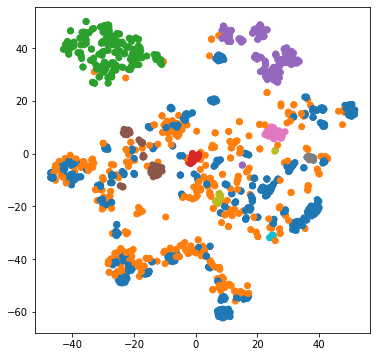

In [73]:
# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(df_plot['x'], df_plot['y'], 
            color=df_plot['color'], 
            label=df_plot['group name'],
            marker='o'
            )

plt.show()

In [74]:
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

In [75]:
mds = MDS(n_components=2, dissimilarity='precomputed')
X_mds = mds.fit_transform(df_dist)

# Perform PCA to further reduce dimensionality (optional)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_mds)

df_plot['x_pca'] = X_pca[:, 0]
df_plot['y_pca'] = X_pca[:, 1]

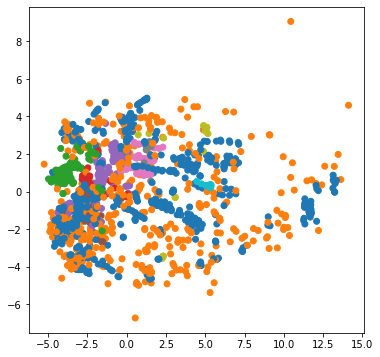

In [76]:
plt.figure(figsize=(6, 6))
plt.scatter(df_plot['x_pca'], df_plot['y_pca'], 
            color=df_plot['color'], 
            label=df_plot['group name'],
            marker='o'
            )

plt.show()

In [78]:
import umap

umap_reducer = umap.UMAP(n_neighbors=10, n_components=2, metric='precomputed')

# Fit and transform the distance matrix using UMAP
embedding = umap_reducer.fit_transform(df_dist)

df_plot['x_umap'] = embedding[:, 0]
df_plot['y_umap'] = embedding[:, 1]


C:\Users\RZ\anaconda3\lib\site-packages\umap\umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


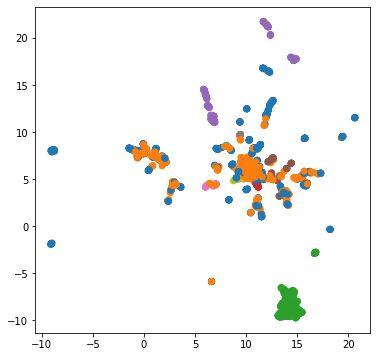

In [79]:
plt.figure(figsize=(6, 6))
plt.scatter(df_plot['x_umap'], df_plot['y_umap'], 
            color=df_plot['color'], 
            label=df_plot['group name'],
            marker='o'
            )

plt.show()